# Interpretability of pain behavior recognition

## First we need dataframes for every subject

In [5]:
import sys
sys.path.append('../')

%matplotlib inline

# DEFINE GRAPH
import pandas as pd
import numpy as np
import utils

from importlib import reload
reload(utils)

pd.set_option('max_colwidth', 800) 

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
# Data paths
rgb_path = '../data/jpg_128_128_2fps/'
of_path = '../data/jpg_128_128_16fps_OF_magnitude_cv2/'

# Hyperparameters
input_width = 128
input_height = 128
seq_length = 10
seq_stride = 10
batch_size = 1
COLOR = True
nb_labels = 2

# Data augmentation
aug_flip = 0
aug_crop = 0
aug_light = 0

subject_ids = pd.read_csv('../metadata/horse_subjects.csv')['Subject'].values
channels = 3

In [8]:
from utils import ArgsProxy
args = ArgsProxy(rgb_path, of_path, input_height, input_width,
                 seq_length, seq_stride, batch_size, nb_labels,
                 aug_flip, aug_crop, aug_light)

In [9]:
import data_handler as dathand
dh = dathand.DataHandler(path=args.data_path,
                 of_path=args.of_path,
                 clip_list_file='videos_overview_missingremoved.csv',
                 data_columns=['Pain'],  # Here one can append f. ex. 'Observer'
                 image_size=(args.input_height, args.input_width),
                 seq_length=args.seq_length,
                 seq_stride=args.seq_stride,
                 batch_size=args.batch_size,
                 color=COLOR,
                 nb_labels=args.nb_labels,
                 aug_flip=args.aug_flip,
                 aug_crop=args.aug_crop,
                 aug_light=args.aug_light)

In [10]:
import utils
subject_dfs = utils.read_or_create_subject_dfs(dh, args, subject_ids)

../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/


In [11]:
subject_dfs = utils.read_or_create_subject_rgb_and_OF_dfs(dh, args, subject_ids, subject_dfs)

In [12]:
sequence_df = utils.get_sequence(args=args, subject_dfs=subject_dfs, subject=4)
y = sequence_df['Pain'].values
image_paths = sequence_df['Path'].values
of_paths = sequence_df['OF_Path'].values

Chose subject  4
Start index in subject dataframe:  4995


In [13]:
from keras.utils import np_utils
label_onehot = np_utils.to_categorical(y, num_classes=args.nb_labels)
label_onehot
batch_label = label_onehot.reshape(args.batch_size, args.seq_length, -1)

batch_img = np.concatenate(utils.read_images_and_return_list(args, image_paths, 'local'), axis=1)
batch_flow = np.concatenate(utils.read_images_and_return_list(args, of_paths, 'local'), axis=1)

## Now that we have frames from all subjects, we can import gradcam functionality

In [1]:
# Choose a model to work on
two_stream = True

best_model_path = '../models/BEST_MODEL_2stream_5d_add_adadelta_LSTMunits_32_CONVfilters_16_add_v4_t1_4hl_128jpg2fps_seq10_bs8_MAG_adadelta_noaug_run1_rerun_for_gradcam.h5'
import keras
m = keras.models.load_model(best_model_path)

Using TensorFlow backend.


In [14]:
from keras import backend as K
import tensorflow as tf
    
images = tf.placeholder(tf.float32, [batch_size, args.seq_length, args.input_width, args.input_height, channels])
flows = tf.placeholder(tf.float32, [batch_size, args.seq_length, args.input_width, args.input_height, channels])
labels = tf.placeholder(tf.float32, [batch_size, args.seq_length, 2])

if two_stream:
    clstm_model = utils.TwoStreamCLSTMNetwork(images, flows, from_scratch=0, path=best_model_path)
else:
    clstm_model = utils.CLSTMNetwork(images, from_scratch=0, path=best_model_path)

sess = K.get_session()  # Grab the Keras session where the weights are initialized.

cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(clstm_model.preds)), axis=1)
    
y_c = tf.reduce_sum(tf.multiply(clstm_model.dense, labels), axis=1)

print('model preds: ', clstm_model.preds)
print('cost: ', cost)
print('y_c: ', y_c)


    
if two_stream:
    target_conv_layer = clstm_model.clstm4_rgb # Choose which CLSTM-layer to study
    # target_conv_layer = clstm_model.clstm1_rgb # Choose which CLSTM-layer to study
    # target_conv_layer = clstm_model.merge # Choose which CLSTM-layer to study
else:
    target_conv_layer = clstm_model.clstm4 # Choose which CLSTM-layer to study
    
print('tcl: ', target_conv_layer)
print('TYPE tcl: ', type(target_conv_layer))
    
target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]

print('tclg: ', target_conv_layer_grad)
    
gb_grad = tf.gradients(cost, [images, flows])[0]  # Guided backpropagation back to input layer

model preds:  Tensor("activation_1_2/Sigmoid:0", shape=(1, 10, 2), dtype=float32)
cost:  Tensor("mul_1:0", shape=(1, 2), dtype=float32)
y_c:  Tensor("Sum_1:0", shape=(1, 2), dtype=float32)
tcl:  Tensor("conv_lst_m2d_4_2/transpose_1:0", shape=(1, ?, 16, 16, 32), dtype=float32)
TYPE tcl:  <class 'tensorflow.python.framework.ops.Tensor'>
tclg:  Tensor("gradients/time_distributed_4_2/transpose_grad/transpose:0", shape=(1, ?, 16, 16, 32), dtype=float32)


In [15]:
def run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True):
    with sess.as_default():

        # 2-stream
        if two_stream:
            prob = sess.run(clstm_model.preds,
                            feed_dict={images: batch_img,
                                       flows: batch_flow,
                                       K.learning_phase(): 0})

            print(prob)

            gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value =                 sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
                          feed_dict={images: batch_img,
                                     flows: batch_flow,
                                     labels: batch_label,
                                     K.learning_phase(): 0})

            target_conv_layer_value = np.reshape(target_conv_layer_value,
                                             (1, 10, 16, 16, 32))
            target_conv_layer_grad_value = np.reshape(target_conv_layer_grad_value,
                                             (1, 10, 16, 16, 32))
            
        else:
            prob = sess.run(clstm_model.preds,
                            feed_dict={images: batch_img,
                                       K.learning_phase(): 0})

            print(prob)
            gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value =                 sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
                          feed_dict={images: batch_img,
                          labels: batch_label,
                          K.learning_phase(): 0})
            target_conv_layer_value = np.reshape(target_conv_layer_value,
                                         (1, 10, 16, 16, 32))
            target_conv_layer_grad_value = np.reshape(target_conv_layer_grad_value,
                                         (1, 10, 16, 16, 32))


        utils.visualize_overlays(batch_img, target_conv_layer_value,
                           target_conv_layer_grad_value, batch_flow)


# Two-stream predictions for subject t1

Chose subject  1
Start index in subject dataframe:  3058
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_1b/frame_000393.jpg     0
1  data/jpg_128_128_2fps/horse_2/2_1b/frame_000394.jpg     0
2  data/jpg_128_128_2fps/horse_2/2_1b/frame_000395.jpg     0
3  data/jpg_128_128_2fps/horse_2/2_1b/frame_000396.jpg     0
4  data/jpg_128_128_2fps/horse_2/2_1b/frame_000397.jpg     0
5  data/jpg_128_128_2fps/horse_2/2_1b/frame_000398.jpg     0
6  data/jpg_128_128_2fps/horse_2/2_1b/frame_000399.jpg     0
7  data/jpg_128_128_2fps/horse_2/2_1b/frame_000400.jpg     0
8  data/jpg_128_128_2fps/horse_2/2_1b/frame_000401.jpg     0
9  data/jpg_128_128_2fps/horse_2/2_1b/frame_000402.jpg     0
[[[0.56537217 0.46998942]
  [0.63968164 0.51580435]
  [0.7411114  0.58053243]
  [0.82688    0.6369445 ]
  [0.9243641  0.54073787]
  [0.9681484  0.22203551]
  [0.9827931  0.07502729]
  [0.9910766  0.03547842]
  [0.99055016 0.02176722]
  [0.9892306  0.03052839]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


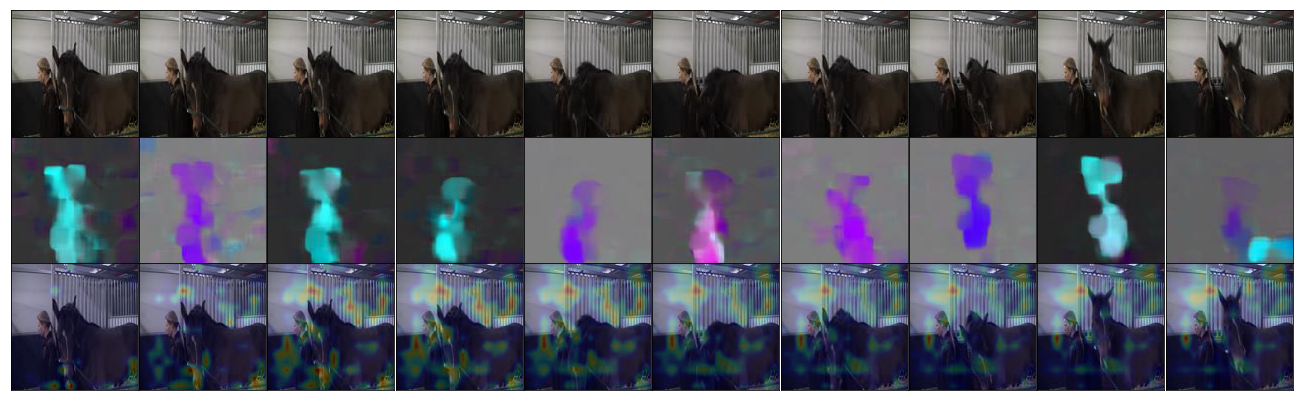

In [16]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=1)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  1
Start index in subject dataframe:  9924
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000867.jpg     1
1  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000868.jpg     1
2  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000869.jpg     1
3  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000870.jpg     1
4  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000871.jpg     1
5  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000872.jpg     1
6  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000873.jpg     1
7  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000874.jpg     1
8  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000875.jpg     1
9  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000876.jpg     1
[[[0.54029065 0.6012691 ]
  [0.45244133 0.8884607 ]
  [0.16505831 0.9745274 ]
  [0.03065883 0.99221003]
  [0.00657006 0.99677616]
  [0.00573953 0.9982835 ]
  [0.0050678  0.99863213]
  [0.00504797 0.99742895]
  [0.0109878  0.9935034 ]
  [0.02584524 0.

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


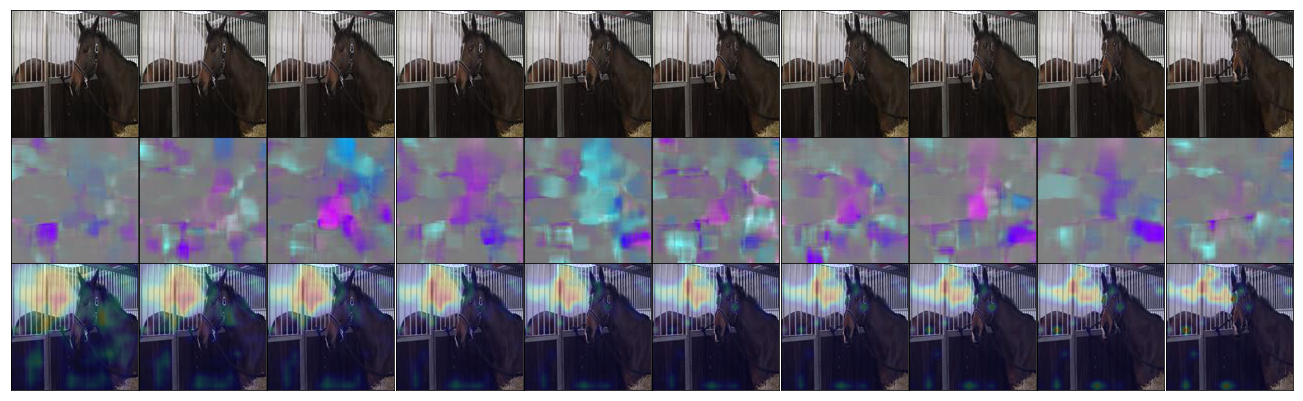

In [17]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=1)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  1
Start index in subject dataframe:  9562
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000505.jpg     1
1  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000506.jpg     1
2  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000507.jpg     1
3  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000508.jpg     1
4  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000509.jpg     1
5  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000510.jpg     1
6  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000511.jpg     1
7  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000512.jpg     1
8  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000513.jpg     1
9  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000514.jpg     1
[[[4.1468853e-01 5.1148230e-01]
  [1.7459016e-01 7.5793260e-01]
  [3.5585221e-02 9.6934044e-01]
  [1.0044780e-02 9.9533468e-01]
  [3.6453167e-03 9.9890625e-01]
  [2.0837360e-03 9.9931979e-01]
  [8.9958485e-04 9.9924529e-01]
  [6.4525893e-04 9.9933124

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


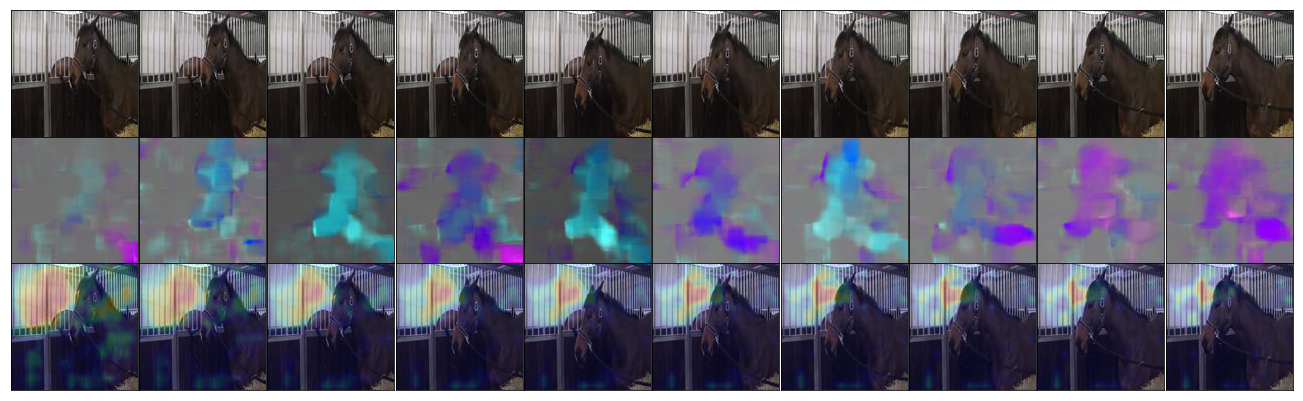

In [18]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=1)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  1
Start index in subject dataframe:  9655
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000598.jpg     1
1  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000599.jpg     1
2  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000600.jpg     1
3  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000601.jpg     1
4  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000602.jpg     1
5  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000603.jpg     1
6  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000604.jpg     1
7  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000605.jpg     1
8  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000606.jpg     1
9  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000607.jpg     1
[[[0.34823853 0.75231236]
  [0.12905106 0.9544233 ]
  [0.04778609 0.99409974]
  [0.01807422 0.99838376]
  [0.00790623 0.99914765]
  [0.00513717 0.9995408 ]
  [0.00311631 0.9996667 ]
  [0.0047157  0.99958616]
  [0.00835133 0.9993648 ]
  [0.01772076 0.

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


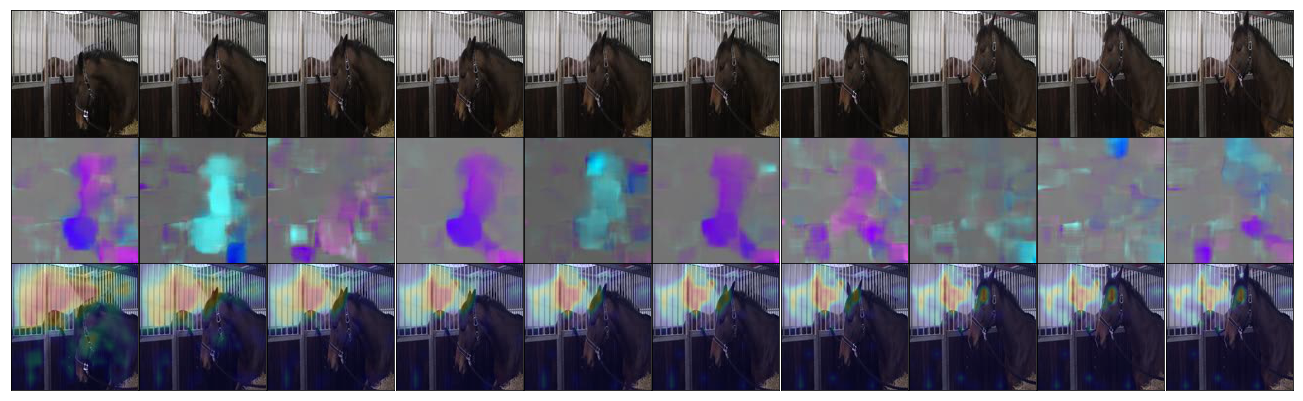

In [20]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=1)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  1
Start index in subject dataframe:  2513
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_1a/frame_002514.jpg     0
1  data/jpg_128_128_2fps/horse_2/2_1a/frame_002515.jpg     0
2  data/jpg_128_128_2fps/horse_2/2_1a/frame_002516.jpg     0
3  data/jpg_128_128_2fps/horse_2/2_1a/frame_002517.jpg     0
4  data/jpg_128_128_2fps/horse_2/2_1a/frame_002518.jpg     0
5  data/jpg_128_128_2fps/horse_2/2_1a/frame_002519.jpg     0
6  data/jpg_128_128_2fps/horse_2/2_1a/frame_002520.jpg     0
7  data/jpg_128_128_2fps/horse_2/2_1a/frame_002521.jpg     0
8  data/jpg_128_128_2fps/horse_2/2_1a/frame_002522.jpg     0
9  data/jpg_128_128_2fps/horse_2/2_1a/frame_002523.jpg     0
[[[0.7037189  0.34171396]
  [0.85216177 0.20533049]
  [0.9304424  0.11017153]
  [0.9611924  0.0702204 ]
  [0.9731967  0.06857703]
  [0.96804124 0.06038435]
  [0.96232    0.07120049]
  [0.95653814 0.10191069]
  [0.93219256 0.13350597]
  [0.9082425  0.18963484]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


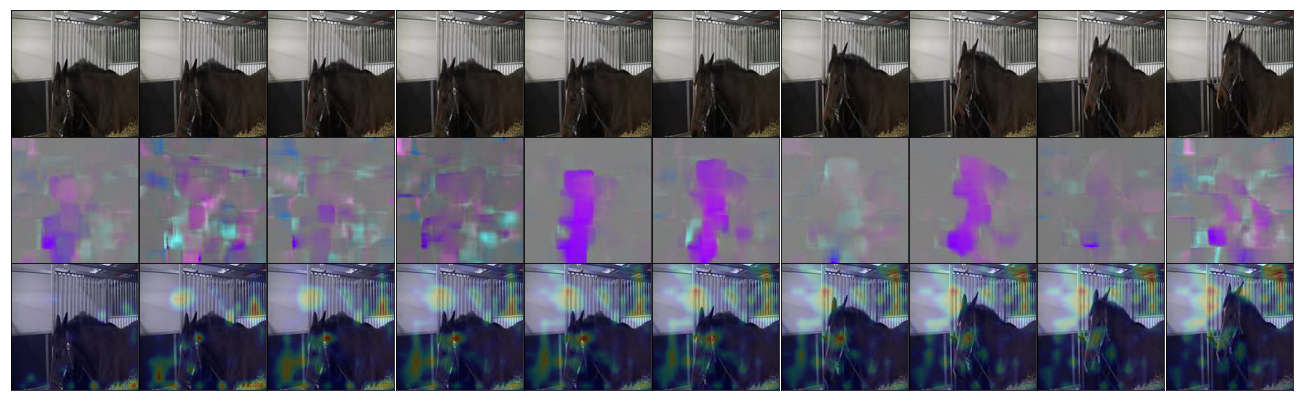

In [21]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=1)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  1
Start index in subject dataframe:  7833
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000456.jpg     1
1  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000457.jpg     1
2  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000458.jpg     1
3  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000459.jpg     1
4  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000460.jpg     1
5  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000461.jpg     1
6  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000462.jpg     1
7  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000463.jpg     1
8  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000464.jpg     1
9  data/jpg_128_128_2fps/horse_2/2_3a_1/frame_000465.jpg     1
[[[0.47495648 0.4979134 ]
  [0.34637386 0.69326204]
  [0.19969252 0.8475053 ]
  [0.16261767 0.9193345 ]
  [0.09498305 0.95434755]
  [0.04717776 0.97026336]
  [0.02420969 0.9751847 ]
  [0.01736446 0.97628057]
  [0.01993696 0.98004353]
  [0.01729234 0.

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


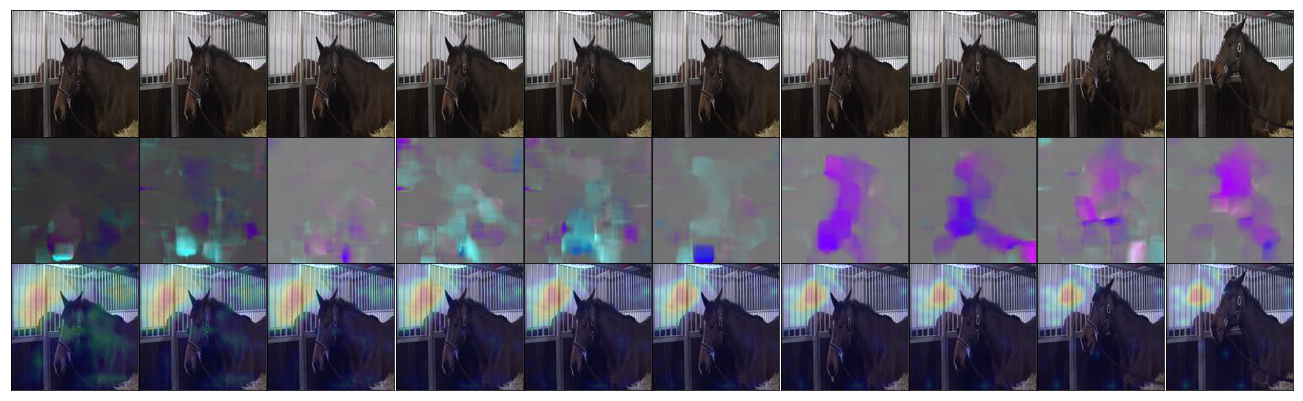

In [23]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=1)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  1
Start index in subject dataframe:  10001
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000944.jpg     1
1  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000945.jpg     1
2  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000946.jpg     1
3  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000947.jpg     1
4  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000948.jpg     1
5  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000949.jpg     1
6  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000950.jpg     1
7  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000951.jpg     1
8  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000952.jpg     1
9  data/jpg_128_128_2fps/horse_2/2_3a_2/frame_000953.jpg     1
[[[0.57170725 0.44469452]
  [0.5188187  0.5695785 ]
  [0.2544859  0.81835127]
  [0.12691009 0.93393916]
  [0.05426874 0.96720034]
  [0.02966421 0.9738917 ]
  [0.03141867 0.9819349 ]
  [0.07104935 0.9894872 ]
  [0.18266879 0.9935941 ]
  [0.35465327 0

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


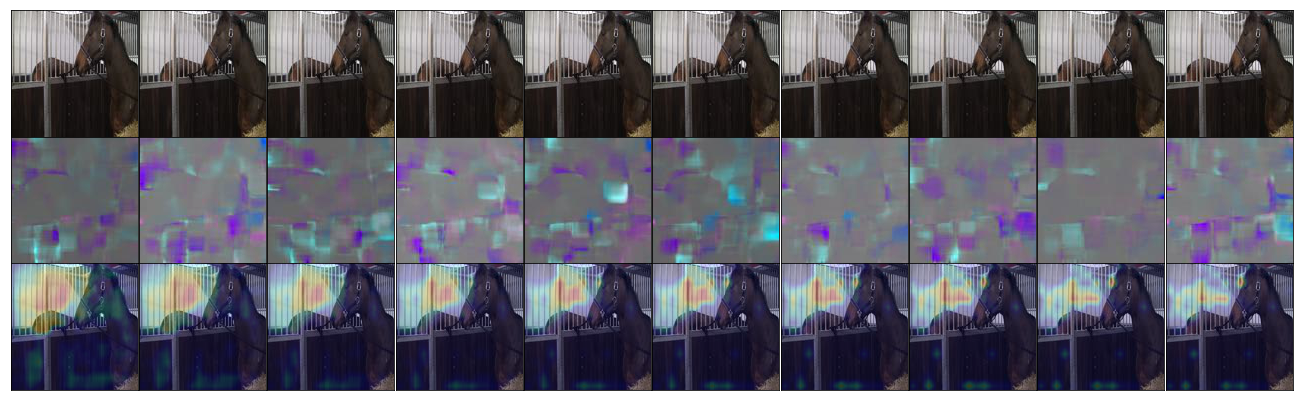

In [24]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=1)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  1
Start index in subject dataframe:  2536
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_1a/frame_002537.jpg     0
1  data/jpg_128_128_2fps/horse_2/2_1a/frame_002538.jpg     0
2  data/jpg_128_128_2fps/horse_2/2_1a/frame_002539.jpg     0
3  data/jpg_128_128_2fps/horse_2/2_1a/frame_002540.jpg     0
4  data/jpg_128_128_2fps/horse_2/2_1a/frame_002541.jpg     0
5  data/jpg_128_128_2fps/horse_2/2_1a/frame_002542.jpg     0
6  data/jpg_128_128_2fps/horse_2/2_1a/frame_002543.jpg     0
7  data/jpg_128_128_2fps/horse_2/2_1a/frame_002544.jpg     0
8  data/jpg_128_128_2fps/horse_2/2_1a/frame_002545.jpg     0
9  data/jpg_128_128_2fps/horse_2/2_1a/frame_002546.jpg     0
[[[0.67207676 0.37269405]
  [0.83587325 0.252998  ]
  [0.91372424 0.14881152]
  [0.9713704  0.08571206]
  [0.9904379  0.05596662]
  [0.99266386 0.06911601]
  [0.9926017  0.06631803]
  [0.99346465 0.04550239]
  [0.9947519  0.04232164]
  [0.9947358  0.03406831]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


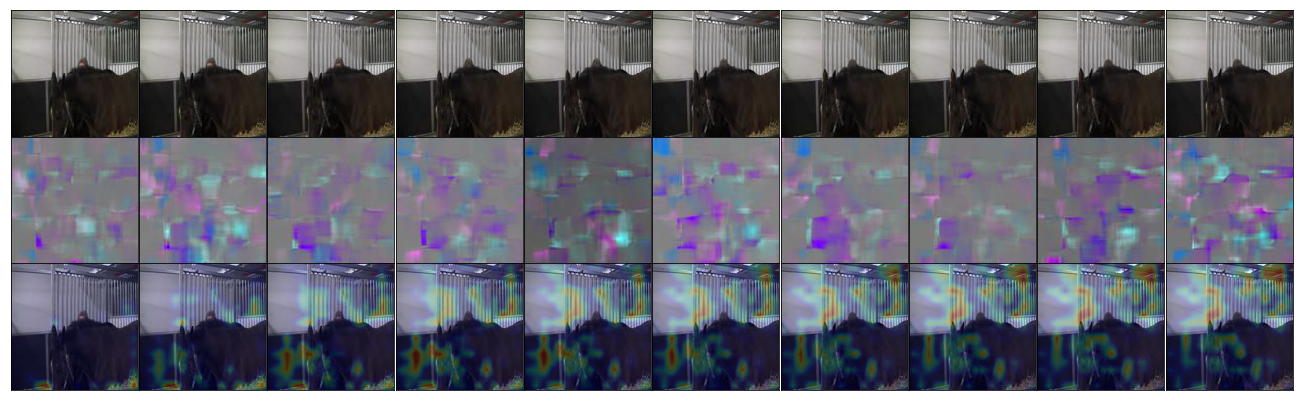

In [25]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=1)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  1
Start index in subject dataframe:  1808
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_1a/frame_001809.jpg     0
1  data/jpg_128_128_2fps/horse_2/2_1a/frame_001810.jpg     0
2  data/jpg_128_128_2fps/horse_2/2_1a/frame_001811.jpg     0
3  data/jpg_128_128_2fps/horse_2/2_1a/frame_001812.jpg     0
4  data/jpg_128_128_2fps/horse_2/2_1a/frame_001813.jpg     0
5  data/jpg_128_128_2fps/horse_2/2_1a/frame_001814.jpg     0
6  data/jpg_128_128_2fps/horse_2/2_1a/frame_001815.jpg     0
7  data/jpg_128_128_2fps/horse_2/2_1a/frame_001816.jpg     0
8  data/jpg_128_128_2fps/horse_2/2_1a/frame_001817.jpg     0
9  data/jpg_128_128_2fps/horse_2/2_1a/frame_001818.jpg     0
[[[0.6369664  0.3672374 ]
  [0.76222974 0.30059993]
  [0.8180047  0.16918848]
  [0.8599763  0.08767702]
  [0.90317965 0.04882685]
  [0.9442089  0.03512141]
  [0.9541975  0.03282259]
  [0.9495793  0.03353144]
  [0.9351084  0.02000393]
  [0.893159   0.0094309 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


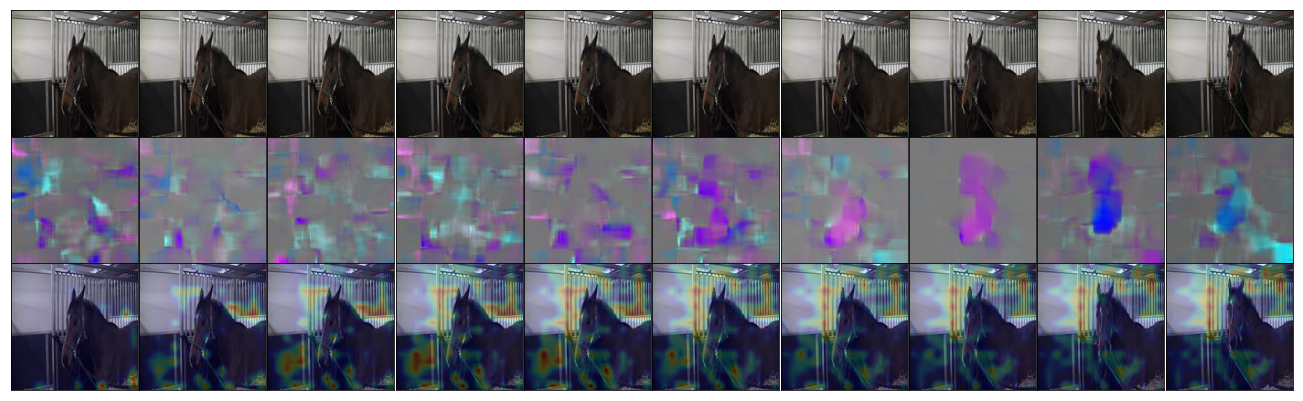

In [31]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=1)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  1
Start index in subject dataframe:  6582
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_2/2_2b/frame_000163.jpg     0
1  data/jpg_128_128_2fps/horse_2/2_2b/frame_000164.jpg     0
2  data/jpg_128_128_2fps/horse_2/2_2b/frame_000165.jpg     0
3  data/jpg_128_128_2fps/horse_2/2_2b/frame_000166.jpg     0
4  data/jpg_128_128_2fps/horse_2/2_2b/frame_000167.jpg     0
5  data/jpg_128_128_2fps/horse_2/2_2b/frame_000168.jpg     0
6  data/jpg_128_128_2fps/horse_2/2_2b/frame_000169.jpg     0
7  data/jpg_128_128_2fps/horse_2/2_2b/frame_000170.jpg     0
8  data/jpg_128_128_2fps/horse_2/2_2b/frame_000171.jpg     0
9  data/jpg_128_128_2fps/horse_2/2_2b/frame_000172.jpg     0
[[[0.65852773 0.32359922]
  [0.9029751  0.102573  ]
  [0.948609   0.02811817]
  [0.9528873  0.01225029]
  [0.9534761  0.01141936]
  [0.9562726  0.01040857]
  [0.9741115  0.0057929 ]
  [0.9744974  0.00758531]
  [0.9675253  0.02064285]
  [0.9652969  0.04998793]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


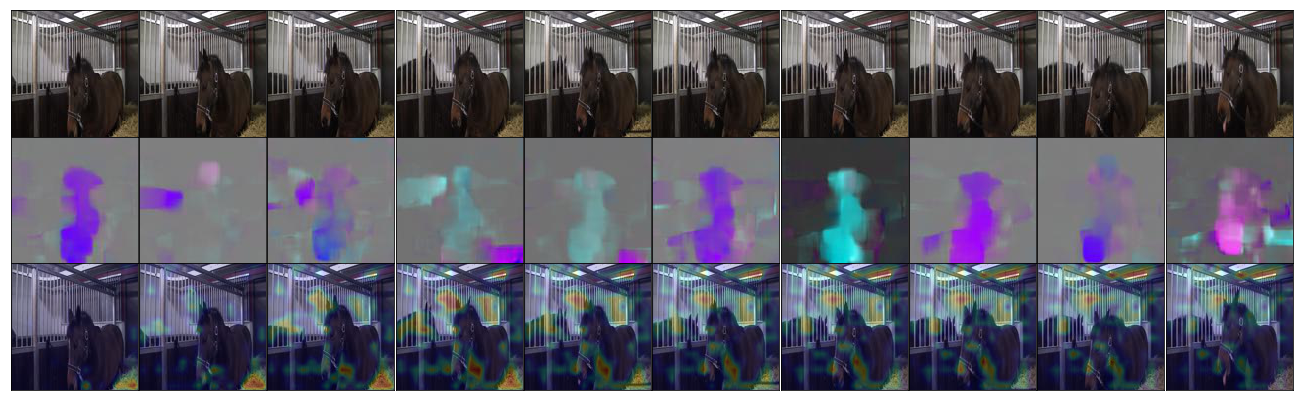

In [32]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=1)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);